In [1]:
import oceanspy as ospy
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import scipy as sp

In [2]:
df = xr.open_dataset('C:/Users/eirik/Master/Data/new_dataset.nc')
df_eta = xr.open_dataset('C:/Users/eirik/Master/Data/Eta.nc')
display(df_eta)

<xarray.Dataset>
Dimensions:    (Z: 1, Zp1: 2, Zu: 1, Zl: 1, X: 853, Y: 628, Xp1: 854, Yp1: 629,
                time: 360, time_midp: 359)
Coordinates: (12/18)
  * Z          (Z) float64 -1.0
  * Zp1        (Zp1) float64 0.0 -2.0
  * Zu         (Zu) float64 -2.0
  * Zl         (Zl) float64 0.0
  * X          (X) float64 -39.85 -39.69 -39.52 -39.37 ... 11.72 11.82 11.92
  * Y          (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    ...         ...
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-03-31T18:00:00
    YU         (Y, Xp1) float64 ...
    XU         (Y, Xp1) float64 ...
    YV         (Yp1, X) float64 ...
    XV         (Yp1, X) float64 ...
  * time_midp  (time_midp) datetime64[ns] 2018-01-01T03:00:00 ... 2018-03-31T...
Data variables:
    Eta        (time, Y, X) float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGP
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

# Starting with defining domain of eddy centerpoint detection and computing eddy centerpoints

In [3]:
domain = [[-20,0],[72,73]]
OW = df['Okubo_Weiss']*(1/(10**(-9)))
eta = df_eta['Eta']
OW = OW.sel(X=slice(domain[0][0],domain[0][1]))
OW = OW.sel(Y=slice(domain[1][0],domain[1][1]))
OW = OW.sel(Z=-1)
eta = eta.sel(X=slice(domain[0][0],domain[0][1]))
eta = eta.sel(Y=slice(domain[1][0],domain[1][1]))

In [4]:
# Resample data to 1 day
OW = OW.resample(time='0.5D').mean(dim='time')
eta = eta.resample(time='0.5D').mean(dim='time')

# Define time extent
time = ['2018-01-01T00:00:00.000000000','2018-01-10T00:00:00.000000000']
eta = eta.sel(time=slice(time[0],time[1]))
OW = OW.sel(time=slice(time[0],time[1]))

In [5]:
# Import algorythm for eddy centerpoint detection
from detection import eddyDetection
import ast

# Set True to run, or read previously file made
run = input('Would you like to run a new dataset? y/n: ')
if run == 'y':
    run = True
elif run == 'n':
    run = False
if run:
    eddyLocation = []
    print('###Applying filter###')
    for i in range(len(eta)):
        eddyLocation.append(eddyDetection(eta[i],OW[i]))
        print('Processing: ',100*(i+1)/len(eta), '%')
    with open("eddyCenterpoints.txt",'w') as f:
        for time in range(len(eddyLocation)):
            if time != len(eddyLocation)-1:
                f.write(str(eddyLocation[time])+',')
            else:
                f.write(str(eddyLocation[time]))

else:
    print('###Loading previously saved eddy centerpoints###')
    with open("eddyCenterpoints.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)

###Loading previously saved eddy centerpoints###


# Defining bigger domain for eddy inner region detection

In [6]:
df_eta = xr.open_dataset('C:/Users/eirik/Master/Data/Eta.nc')

eta = df_eta['Eta']
# Resample data to 1 day
eta = eta.resample(time='0.5D').mean(dim='time')

eta = eta.sel(X=slice(domain[0][0]-2,domain[0][1]+2))
eta = eta.sel(Y=slice(domain[1][0]-2,domain[1][1]+2))
time = ['2018-01-01T00:00:00.000000000','2018-01-10T00:00:00.000000000']
eta = eta.sel(time=slice(time[0],time[1]))

In [7]:
from tqdm import tqdm
from detection import full_inner_eddy_region

run = input('Would you like to run a new dataset? y/n: ')
if run == 'y':
    run = True
elif run == 'n':
    run = False

if run:
    eddy_centers = eddyLocation
    T = len(eddyLocation)*(len(eddyLocation[0][0]) + len(eddyLocation[0][1]))
    pbar = tqdm(total=T, desc="Running algorythm")
    eddies = xr.full_like(eta,fill_value=0)
    eddies = eddies.rename("EddyDetection")
    for time in range(len(eddyLocation)):
        # First run per time step
        
        
        eddyDataset = full_inner_eddy_region(eta=eta[time],eddy_center=eddy_centers[time][0][0],warm=True,eddiesDataset=eddies[time])
        pbar.update(1)
        for i in range(1,len(eddy_centers[time][0])):
            eddyDataset = full_inner_eddy_region(eta=eta[time],eddy_center=eddy_centers[time][0][i],warm=True,eddiesDataset=eddyDataset)
            pbar.update(1)
            
        for i in range(0,len(eddy_centers[time][1])):
            eddyDataset = full_inner_eddy_region(eta=eta[time],eddy_center=eddy_centers[time][1][i],cold=True,eddiesDataset=eddyDataset)
            pbar.update(1)
            
        eddies[time] = eddyDataset
    eddies.to_netcdf('C:/Users/eirik/Master/Data/Eddies.nc')
else:
    eddies = xr.open_dataset('C:/Users/eirik/Master/Data/Eddies.nc')
    eddies = eddies['EddyDetection']

Running algorythm:   4%|▍         | 25/646 [00:17<10:13,  1.01it/s]

KeyboardInterrupt: 

Generating Frames:  69%|██████▉   | 27/39 [02:49<01:15,  6.28s/it]


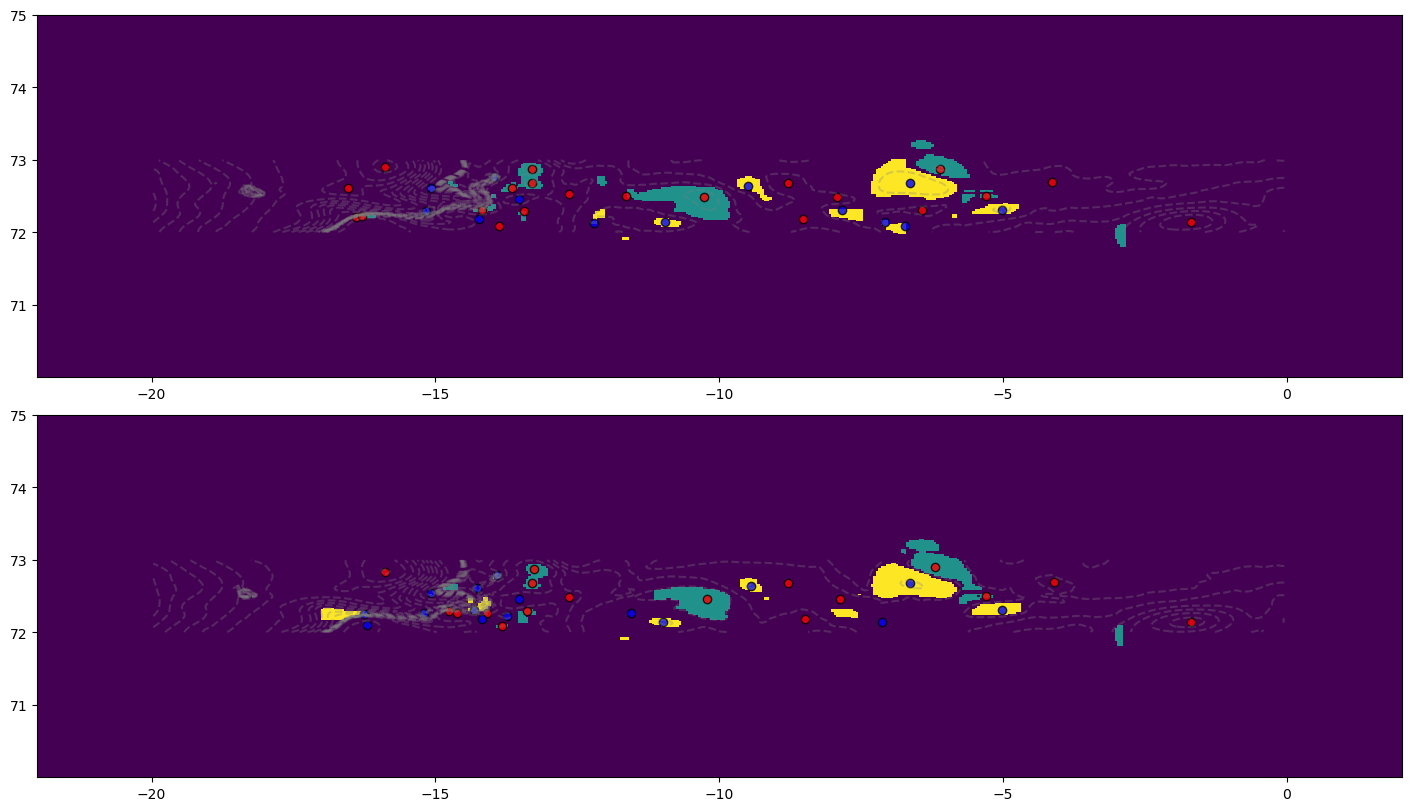

In [9]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8),layout='constrained')
ax1.pcolormesh(eddies[0].X,eddies[0].Y,eddies[0])
cntr = ax1.contour(eta[0].X,eta[0].Y,eta[0],np.linspace(-0.4,0.1,21),colors='grey',alpha=0.3)

for i in eddyLocation[0][0]:
    sct1 = ax1.scatter(i[1],i[0],color='red',edgecolor='black',alpha=0.8)


for i in eddyLocation[0][1]:
    sct2 = ax1.scatter(i[1],i[0],color='blue',edgecolor='black',alpha=0.8)


ax2.pcolormesh(eddies[1].X,eddies[1].Y,eddies[1])
cntr = ax2.contour(eta[1].X,eta[1].Y,eta[1],np.linspace(-0.4,0.1,21),colors='grey',alpha=0.3)

for i in eddyLocation[1][0]:
    sct1 = ax2.scatter(i[1],i[0],color='red',edgecolor='black',alpha=0.8)


for i in eddyLocation[1][1]:
    sct2 = ax2.scatter(i[1],i[0],color='blue',edgecolor='black',alpha=0.8)

# Remove eddy centers which is not in a defined inner eddy region

In [11]:
display(eddies)

<xarray.DataArray 'EddyDetection' (time: 29, Y: 231, X: 510)>
[3416490 values with dtype=float64]
Coordinates:
  * X        (X) float64 -21.98 -21.93 -21.87 -21.82 ... 1.822 1.879 1.936 1.994
  * Y        (Y) float64 70.01 70.03 70.04 70.06 ... 74.89 74.92 74.95 74.99
    XC       (Y, X) float64 ...
    YC       (Y, X) float64 ...
  * time     (time) datetime64[ns] 2018-01-01 2018-01-01T12:00:00 ... 2018-01-15
Attributes:
    long_name:      free-surface_r-anomaly
    units:          m
    standard_name:  sea_surface_height_above_geoid
    _coordinates:   XC YC iter

In [12]:
clean_eddy_centers = []
for time in range(len(eddyLocation)):
    time_eddy_centers = [[],[]]
    for eddy_center in eddyLocation[time][0]: # warm
        eddy_centers = [np.argwhere(eddies.Y.values == eddy_center[0])[0][0],np.argwhere(eddies.X.values == eddy_center[1])[0][0]]
        if eddies[time][eddy_centers[0]][eddy_centers[1]]:
            time_eddy_centers[0].append(eddy_center)
    for eddy_center in eddyLocation[time][1]: # cold
        eddy_centers = [np.argwhere(eddies.Y.values == eddy_center[0])[0][0],np.argwhere(eddies.X.values == eddy_center[1])[0][0]]
        if eddies[time][eddy_centers[0]][eddy_centers[1]]:
            time_eddy_centers[1].append(eddy_center)
    clean_eddy_centers.append(time_eddy_centers)

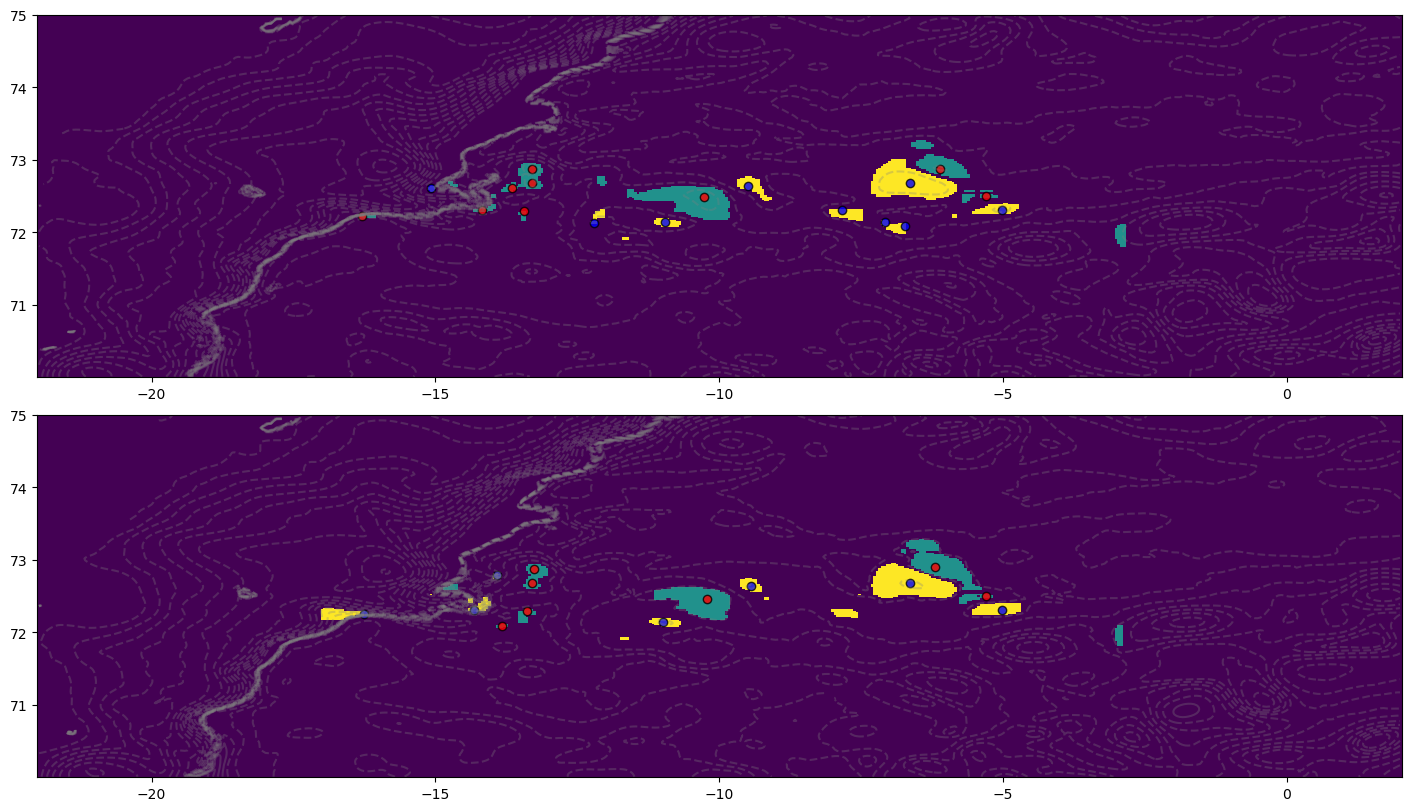

In [13]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8),layout='constrained')
ax1.pcolormesh(eddies[0].X,eddies[0].Y,eddies[0])
cntr = ax1.contour(eta[0].X,eta[0].Y,eta[0],np.linspace(-0.4,0.1,21),colors='grey',alpha=0.3)

for i in clean_eddy_centers[0][0]:
    sct1 = ax1.scatter(i[1],i[0],color='red',edgecolor='black',alpha=0.8)


for i in clean_eddy_centers[0][1]:
    sct2 = ax1.scatter(i[1],i[0],color='blue',edgecolor='black',alpha=0.8)


ax2.pcolormesh(eddies[1].X,eddies[1].Y,eddies[1])
cntr = ax2.contour(eta[1].X,eta[1].Y,eta[1],np.linspace(-0.4,0.1,21),colors='grey',alpha=0.3)

for i in clean_eddy_centers[1][0]:
    sct1 = ax2.scatter(i[1],i[0],color='red',edgecolor='black',alpha=0.8)


for i in clean_eddy_centers[1][1]:
    sct2 = ax2.scatter(i[1],i[0],color='blue',edgecolor='black',alpha=0.8)

# Animate the eddies

In [14]:
from IPython.display import Video, display
from animation import animation_local_gif

df_depth = xr.open_dataset('C:/Users/eirik/Master/Data/depth.nc')
depth = df_depth['Depth'].sel(X=slice(eddies.X[0], eddies.X[-1])).sel(Y=slice(eddies.Y[0], eddies.Y[-1]))

animation_local_gif(data=eddies,name='Eddies_05D',unit='No eddy, Warm eddy, Cold eddy',depth=depth)



Generating Frames:  77%|███████▋  | 30/39 [03:33<01:03,  7.11s/it]
Generating Frames: 59it [00:25,  2.32it/s]                        


In [8]:
# Import necessary libraries
from PIL import Image
import IPython.display as ipy_display
import ipywidgets as widgets
import xarray as xr

# Load the depth dataset
df_depth = xr.open_dataset('C:/Users/eirik/Master/Data/depth.nc')
depth = df_depth['Depth'].sel(X=slice(eddies.X[0], eddies.X[-1])).sel(Y=slice(eddies.Y[0], eddies.Y[-1]))

# Load the GIF
gif_path = 'C:/Users/eirik/Master/Eddies.gif'
gif = Image.open(gif_path)

# Extract frames
frames = []
try:
    while True:
        frames.append(gif.copy())
        gif.seek(len(frames))  # Move to the next frame
except EOFError:
    pass  # End of sequence

# Function to display a specific frame
def display_frame(frame_number):
    if 0 <= frame_number < len(frames):
        ipy_display.display(frames[frame_number])
    else:
        print("Frame number out of range")

# Create a slider to select the frame
frame_slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, step=1, description='Frame:')

# Create an output widget to display the frame
output = widgets.Output()

# Define a function to update the displayed frame
def update_frame(change):
    with output:
        output.clear_output(wait=True)
        display_frame(change['new'])

# Attach the update function to the slider
frame_slider.observe(update_frame, names='value')

# Display the slider and the output widget
ipy_display.display(frame_slider, output)

# Display the initial frame within the output widget
with output:
    display_frame(0)

IntSlider(value=0, description='Frame:', max=89)

Output()

In [16]:
# Load the GIF
gif_path = 'C:/Users/eirik/Master/Eddies_05D.gif'
gif = Image.open(gif_path)

# Extract frames
frames = []
try:
    while True:
        frames.append(gif.copy())
        gif.seek(len(frames))  # Move to the next frame
except EOFError:
    pass  # End of sequence

# Function to display a specific frame
def display_frame(frame_number):
    if 0 <= frame_number < len(frames):
        ipy_display.display(frames[frame_number])
    else:
        print("Frame number out of range")

# Create a slider to select the frame
frame_slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, step=1, description='Frame:')

# Create an output widget to display the frame
output = widgets.Output()

# Define a function to update the displayed frame
def update_frame(change):
    with output:
        output.clear_output(wait=True)
        display_frame(change['new'])

# Attach the update function to the slider
frame_slider.observe(update_frame, names='value')

# Display the slider and the output widget
ipy_display.display(frame_slider, output)

# Display the initial frame within the output widget
with output:
    display_frame(0)

IntSlider(value=0, description='Frame:', max=28)

Output()